In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import time
import pysuperansac
import sys
import cv2
import io
import requests
from PIL import Image
from romatch import roma_outdoor

In [8]:
def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename

#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [9]:
# Parameters
device = torch.device('cuda')

# Initialize the detector and matcher
detector = roma_outdoor(device = device)

/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)


In [10]:
# Download the images
url_a = "https://github.com/kornia/data/raw/main/homography/img1.ppm"
url_b = "https://github.com/kornia/data/raw/main/homography/img2.ppm"

download_image(url_a)
download_image(url_b)

img1 = cv2.cvtColor(cv2.imread("img1.ppm", cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("img2.ppm", cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB)

torch_img1 = torch.from_numpy(img1).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.
torch_img2 = torch.from_numpy(img2).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.

10000 RoMA matches are found in 1.15 seconds


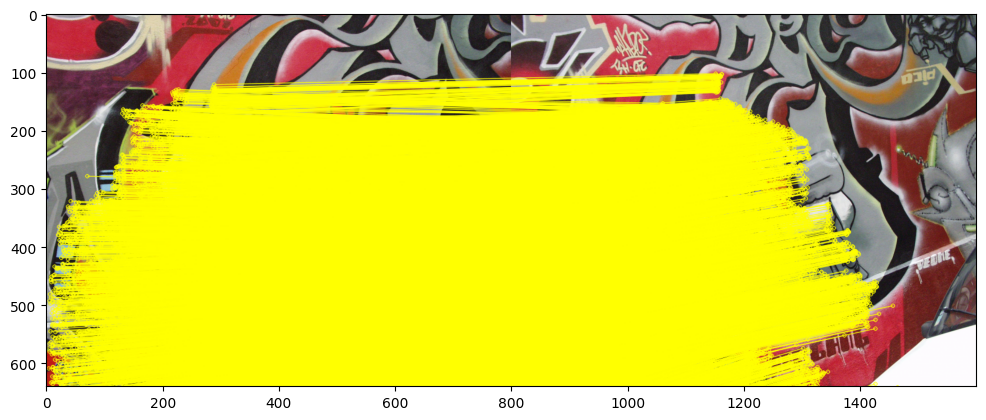

In [11]:
start_time = time.time()
warp, certainty = detector.match("kn_church-2.jpg", "kn_church-8.jpg", device = device)
# Sample matches for estimation
matches, certainty = detector.sample(warp, certainty)
# Convert to pixel coordinates (RoMa produces matches in [-1,1]x[-1,1])
W_A, H_A = Image.open("kn_church-2.jpg").size
W_B, H_B = Image.open("kn_church-8.jpg").size
kptsA, kptsB = detector.to_pixel_coordinates(matches, H_A, W_A, H_B, W_B)

matches = np.hstack((kptsA.cpu().numpy(), kptsB.cpu().numpy()))
end_time = time.time()

print(f"{matches.shape[0]} RoMA matches are found in {end_time - start_time:.2f} seconds")

# Order by the score
draw_matches([cv2.KeyPoint(matches[i][0], matches[i][1], 1) for i in range(matches.shape[0])], 
             [cv2.KeyPoint(matches[i][2], matches[i][3], 1) for i in range(matches.shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(matches.shape[0])], 
             img1, img2, 
             np.array(matches.shape[0] * [1]))

In [14]:
def run_cv2_hom(matches):
    # Run the fundamental matrix estimation implemented in OpenCV
    tic = time.perf_counter()
    src_pts = matches[:,0:2]
    dst_pts = matches[:,2:4]
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.USAC_MAGSAC, 1.5)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print (f'{int(deepcopy(mask).astype(np.float32).sum())} inliers found by OpenCV (USAC_MAGSAC) in {elapsed_time:0.3f} seconds')
    return H, mask

def run_superansac(matches, config, image_size1, image_size2):
    # Run the fundamental matrix estimation implemented in SupeRANSAC
    tic = time.perf_counter()
    H, inliers, score, iterations = pysuperansac.estimateHomography(
        np.ascontiguousarray(matches), 
        [],
        [image_size1[2], image_size1[1], image_size2[2], image_size2[1]],
        config = config)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print (f'{len(inliers)} inliers found by SupeRANSAC in {elapsed_time:0.3f} seconds')

    mask = np.zeros((matches.shape[0], 1), dtype=np.uint8)
    mask[inliers] = 1

    return H, mask


531 inliers found by OpenCV (USAC_MAGSAC) in 0.014 seconds
1828 inliers found by SupeRANSAC in 0.199 seconds


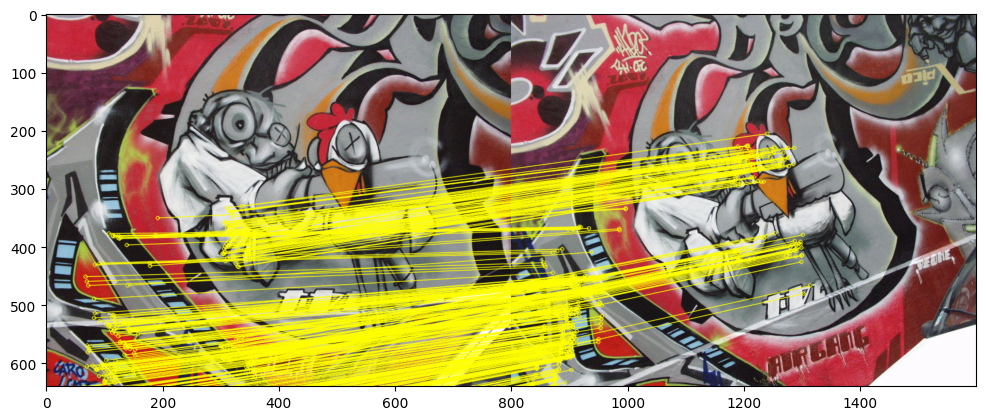

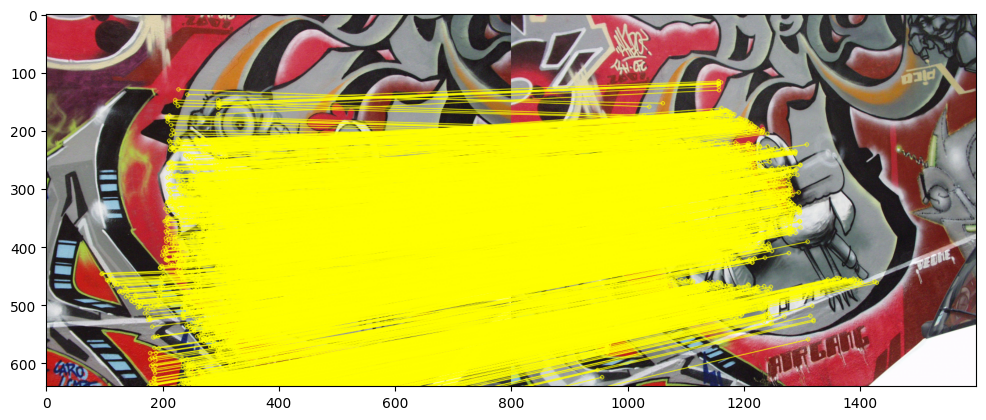

In [ ]:
# Set up the configuration
config = pysuperansac.RANSACSettings()
config.inlier_threshold = 2.0
config.min_iterations = 1000
config.max_iterations = 50
config.confidence = 0.999
config.sampler = pysuperansac.SamplerType.PROSAC
config.scoring = pysuperansac.ScoringType.MAGSAC
config.local_optimization = pysuperansac.LocalOptimizationType.NestedRANSAC
config.final_optimization = pysuperansac.LocalOptimizationType.IteratedLSQ
config.neighborhood_settings.neighborhood_grid_density = 6
config.neighborhood_settings.neighborhood_size = 6

# Run OpenCV RANSAC 
H_cv2, mask_cv2 = run_cv2_hom(matches)

# Run OpenCV RANSAC 
H_sr, mask_sr = run_superansac(matches, config, img1.shape, img2.shape)

draw_matches([cv2.KeyPoint(matches[i][0], matches[i][1], 1) for i in range(matches.shape[0])], 
             [cv2.KeyPoint(matches[i][2], matches[i][3], 1) for i in range(matches.shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(matches.shape[0])], 
             img1, img2, 
             mask_cv2)

draw_matches([cv2.KeyPoint(matches[i][0], matches[i][1], 1) for i in range(matches.shape[0])], 
             [cv2.KeyPoint(matches[i][2], matches[i][3], 1) for i in range(matches.shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(matches.shape[0])], 
             img1, img2, 
             mask_sr)